In [82]:
import duckdb
import networkx as nx
import json
import pandas as pd

from pyvis.network import Network
import matplotlib.pyplot as plt

In [92]:
# name of the JSON column 
X_SHOP_LOCAL_BRANDS_PCT = 'RELATED_CROSS_SHOPPING_LOCAL_BRANDS_PCT'
LOCATION_NAME = 'LOCATION_NAME'
TOP_CATEGORY = 'TOP_CATEGORY'
RAW_NUM_CUSTOMERS = 'RAW_NUM_CUSTOMERS'

In [ ]:
r1 = duckdb.read_parquet('data/san-diego-county-spend-patterns.parquet')
df = r1.to_df()
df.head()

,BRANDS,BUCKETED_CUSTOMER_FREQUENCY,BUCKETED_CUSTOMER_INCOMES,CITY,CUSTOMER_HOME_CITY,DAY_COUNTS,LOCATION_NAME,MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY,MEAN_SPEND_PER_CUSTOMER_BY_INCOME,MEDIAN_SPEND_PER_CUSTOMER,...,SPEND_DATE_RANGE_END,SPEND_DATE_RANGE_START,SPEND_PCT_CHANGE_VS_PREV_MONTH,SPEND_PCT_CHANGE_VS_PREV_YEAR,SPEND_PER_TRANSACTION_BY_DAY,SPEND_PER_TRANSACTION_PERCENTILES,STREET_ADDRESS,SUB_CATEGORY,TOP_CATEGORY,TRANSACTION_INTERMEDIARY
0,Jack in the Box,"{""1"":4,""2"":0,""3"":0,""4"":0,""5-10"":0,"">10"":0}","{""60-75k"":2,""75-100k"":2,"">150k"":3}",National City,"{""key_value"":[{""key"":"", ND"",""value"":2},{""key"":...","{""Friday"":4,""Monday"":4,""Saturday"":4,""Sunday"":4...",Jack in the Box,"{""1"":22.04}","{""60-75k"":5.96,""75-100k"":19.87,"">150k"":31.16}",25.52,...,2025-08-01,2025-07-01,NaN,NaN,"[null,null,31.16,null,null,null,null,5.96,null...","{""25"":9.44,""75"":31.16}",700 Roosevelt Ave,Limited-Service Restaurants,Restaurants and Other Eating Places,"{""key_value"":[{""key"":""No intermediary"",""value""..."
1,Walmart,"{""1"":1378,""2"":288,""3"":73,""4"":34,""5-10"":48,"">10...","{""100-150k"":212,""25-45k"":340,""45-60k"":239,""60-...",Poway,"{""key_value"":[{""key"":""Richland, WA"",""value"":2}...","{""Friday"":4,""Monday"":4,""Saturday"":4,""Sunday"":4...",Walmart Supercenter,"{""1"":45.64,""2"":91.39,""3"":210.87,""4"":164.88,""5-...","{""100-150k"":63.73,""25-45k"":48.44,""45-60k"":51.1...",33.93,...,2025-08-01,2025-07-01,36.0,167.0,"[28.69,39.41,68.28,26.95,18.77,49.75,30.63,28....","{""25"":12,""75"":46.7}",13425 Community Rd,Warehouse Clubs and Supercenters,"General Merchandise Stores, including Warehous...","{""key_value"":[{""key"":""No intermediary"",""value""..."
2,Carl's Jr.,"{""1"":18,""2"":1,""3"":0,""4"":0,""5-10"":0,"">10"":0}","{""100-150k"":2,""25-45k"":2,""45-60k"":2,""60-75k"":2...",La Mesa,"{""key_value"":[{""key"":""Encinitas, CA"",""value"":2...","{""Friday"":4,""Monday"":4,""Saturday"":4,""Sunday"":4...",Carl's Jr.,"{""1"":18.13,""2"":26.11}","{""100-150k"":24.16,""25-45k"":11.38,""45-60k"":26.3...",16.14,...,2025-08-01,2025-07-01,55.0,7.0,"[24.71,null,null,16.14,null,null,24.16,null,7....","{""25"":12.56,""75"":24.57}",8110 Parkway Dr,Limited-Service Restaurants,Restaurants and Other Eating Places,"{""key_value"":[{""key"":""No intermediary"",""value""..."
3,24 Hour Fitness,"{""1"":2,""2"":1,""3"":1,""4"":0,""5-10"":0,"">10"":0}","{""25-45k"":2,"">150k"":2}",San Diego,"{""key_value"":[{""key"":""Lakeside, CA"",""value"":2}...","{""Friday"":4,""Monday"":4,""Saturday"":4,""Sunday"":4...",24 Hour Fitness,"{""1"":4.78,""2"":40,""3"":21.25}","{""25-45k"":10.27,"">150k"":40}",13.37,...,2025-08-01,2025-07-01,NaN,NaN,"[null,null,null,null,20,5.48,null,null,null,8....","{""25"":4.29,""75"":20}",5885 Rancho Mission Rd,Fitness and Recreational Sports Centers,Other Amusement and Recreation Industries,"{""key_value"":[{""key"":""No intermediary"",""value""..."
4,Great Clips,"{""1"":10,""2"":3,""3"":0,""4"":0,""5-10"":0,"">10"":0}","{""100-150k"":2,""25-45k"":2,""45-60k"":2,""60-75k"":2...",Oceanside,"{""key_value"":[{""key"":""Oceanside, CA"",""value"":9...","{""Friday"":4,""Monday"":4,""Saturday"":4,""Sunday"":4...",Great Clips,"{""1"":33.6,""2"":51.67}","{""100-150k"":46,""25-45k"":31.5,""45-60k"":33.66,""6...",35.00,...,2025-08-01,2025-07-01,-4.0,-6.0,"[null,null,null,null,26,null,39,24.5,28,30,nul...","{""25"":25.99,""75"":34}",3825 Mission Ave,Beauty Salons,Personal Care Services,"{""key_value"":[{""key"":""No intermediary"",""value""..."


In [84]:
df['RELATED_CROSS_SHOPPING_LOCAL_BRANDS_PCT'].head()

0                                                 None
1    {"key_value":[{"key":"Trader Joe's","value":2}...
2    {"key_value":[{"key":"Walmart","value":16},{"k...
3    {"key_value":[{"key":"7-Eleven","value":25},{"...
4    {"key_value":[{"key":"Albertsons","value":16},...
Name: RELATED_CROSS_SHOPPING_LOCAL_BRANDS_PCT, dtype: object

In [85]:
def parse_json_to_tuple(json_str: str) -> list[tuple[str, int]]:
    if not json_str:
        return None
    try:
        data_dict = json.loads(json_str)

        # Handle the nested structure
        if isinstance(data_dict, dict) and "key_value" in data_dict:
            return [(item["key"], item["value"]) for item in data_dict["key_value"]]

        # If it's already a flat dict
        elif isinstance(data_dict, dict):
            return [(k, v) for k, v in data_dict.items()]

        # If it's a list of dicts already
        elif isinstance(data_dict, list):
            return [(item["key"], item["value"]) for item in data_dict]

        return None
    except (ValueError, SyntaxError, KeyError, TypeError):
        return None

In [86]:
G = nx.DiGraph()

df['parsed_brands'] = df[X_SHOP_LOCAL_BRANDS_PCT].apply(parse_json_to_tuple)

In [87]:
df['parsed_brands'].head()

0                                                 None
1    [(Trader Joe's, 2), (Target, 4), (Chevron, 1),...
2    [(Walmart, 16), (Chili's Grill & Bar, 6), (Tra...
3                         [(7-Eleven, 25), (Zara, 25)]
4    [(Albertsons, 16), (Domino's Pizza, 8), (7-Ele...
Name: parsed_brands, dtype: object

In [ ]:
def add_nodes_and_edges(row):
    location = row[LOCATION_NAME]
    category = row[TOP_CATEGORY]
    raw_num_customers = row[RAW_NUM_CUSTOMERS]
    
    # add node
    G.add_node(location, label=location, category=category, num_customers=raw_num_customers)

    # add edges
    parsed_brands = row['parsed_brands']
    if parsed_brands:
        for brand, pct in parsed_brands:
            weight = pct / 100
            if weight > .01:
                G.add_edge(location, brand, weight=weight)

In [95]:
df.apply(add_nodes_and_edges, axis=1)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 4587
Number of edges: 45966


## Export Graph to GEXF

In [96]:
# export the graph to a GEXF file for visualization in Gephi
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = f"graph_{timestamp}.gexf"
nx.write_gexf(G, output_file)

In [97]:
print(len(list(G.nodes)))
print(len(list(G.edges)))
#print(len(list(nx.connected_components(G)))) # only works for undirected graphs

4587
45966


## Clustering

In [ ]:
clusters = nx.clustering(G)
sorted(clusters.items(), key=lambda item: item[1], reverse=True)

[('Five Below', 1.0),
 ('American Eagle Outfitters', 1.0),
 ("Charley's", 1.0),
 ('H&M (Hennes & Mauritz)', 1.0),
 ('Petco', 1.0),
 ('Burger King', 1.0),
 ('Buffalo Wild Wings', 0.8),
 ('ShopRite', 0.5),
 ('T.J. Maxx', 0.4),
 ('Pilot Flying J', 0.3333333333333333),
 ('PetSmart', 0.3333333333333333),
 ('Old Navy', 0.3333333333333333),
 ('IHOP', 0.3333333333333333),
 ('Family Dollar Stores', 0.3333333333333333),
 ('JCPenney', 0.3333333333333333),
 ("Casey's General Stores", 0.3333333333333333),
 ('Bartz Viviano Flowers & Gifts', 0.3333333333333333),
 ('Tire Discounters', 0.3090909090909091),
 ('Rodeway Inn', 0.3),
 ('Murphy USA', 0.2909090909090909),
 ('Chipotle Mexican Grill', 0.2857142857142857),
 ('VACHON CHEVROLET INC', 0.26666666666666666),
 ('Speedway', 0.2222222222222222),
 ('Stop & Shop', 0.2),
 ("Wendy's", 0.19117647058823528),
 ('Wawa', 0.19047619047619047),
 ('Tuckerton Car Wash', 0.19047619047619047),
 ('Palace Pizza & More', 0.19047619047619047),
 ('Drum Point Marina', 0.178

## Isolated Nodes

In [98]:
# find isolated nodes
isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes: {len(isolated_nodes)}")
print("Isolated nodes:", isolated_nodes)


Number of isolated nodes: 868
Isolated nodes: ['Meza Paints', 'Fish Market Sushi Bar', 'Kearny Mesa Farmers Market', 'Newport Avenue Optometry', 'Options For All', 'Home2 Suites', 'Walmart Pharmacy', 'MOSSY NISSAN EL CAJON', 'Rocket', 'Copley-price Family Ymca', 'MINI of Escondido', 'Courtyard San Diego Rancho Bernardo', 'Best Western Escondido Hotel', 'CarMax', 'Ball Honda', 'ECCO', "Patty's Cafe La Mesa", 'Ftd', 'LiVa Distributor', 'Roya', 'Everyday California', "Jerry's Mkt", 'The Wild Thyme Company', 'The Waterfront Bar & Grill', 'Casablanca Lounge', "Bud's Louisiana Cafe", 'Horton Plaza', 'Delicias Taco Shop', 'Deuce Brand', 'Marble Express', 'PorchLight', 'Primos', 'Ashley Furniture', 'Courtyard San Diego Airport Liberty Station', 'Kiko Sven', 'Floral Supply Syndicate', 'Tower 23', 'J and J', 'Real World Scholars', 'Sunday Assembly', 'Sunset Pharmaceuticals Inc.', 'Great American Grill R', 'USD Torero Store', 'Greene Cat Liquors', 'Delicious Treats', "D'liteful Chocolat", 'Baja F

## Degree Analysis

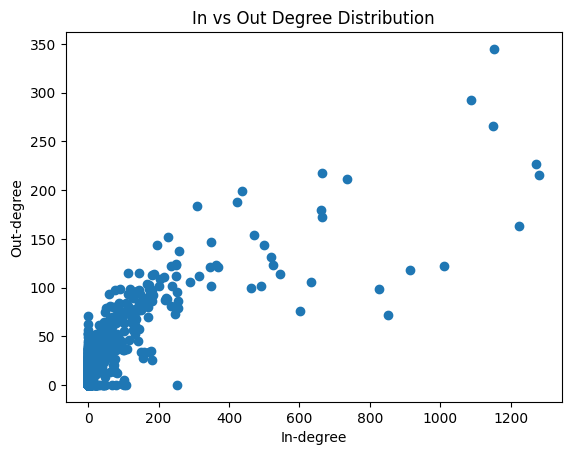

In [ ]:
# find most influential nodes using out_degree 
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

plt.scatter(in_degrees.values(), out_degrees.values())
plt.xlabel("In-degree")
plt.ylabel("Out-degree")
plt.title("In vs Out Degree Distribution")
plt.show()

In [ ]:
# find the 10 nodes with the most out_degree
top_out_degree = sorted(out_degrees.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 nodes by out-degree:")
for node, degree in top_out_degree:
    print(f"{node}: {degree}")  

# find the 10 nodes with the most in_degree
top_in_degree = sorted(in_degrees.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 nodes by in-degree:")
for node, degree in top_in_degree:
    print(f"{node}: {degree}")  

Top 10 nodes by out-degree:
Starbucks: 345
7-Eleven: 293
Chevron: 266
CVS: 227
Panda Express: 218
McDonald's: 216
Jack in the Box: 211
Jersey Mike's: 199
Domino's Pizza: 188
Subway: 184
Top 10 nodes by in-degree:
McDonald's: 1281
CVS: 1271
Vons: 1225
Starbucks: 1152
Chevron: 1150
7-Eleven: 1087
Target: 1011
Ralphs: 913
Walmart: 852
Trader Joe's: 825


## 2nd Degree Neighbors

In [106]:
G.nodes["ALDI"]

{'label': 'ALDI', 'category': 'Grocery Stores', 'num_customers': 29.0}

In [109]:
node = "ALDI" # node of interest

# First-degree neighbors
first_deg = set(G.neighbors(node))

# Second-degree = neighbors of neighbors, excluding self and first-degree
second_deg = set()
for n in first_deg:
    second_deg.update(G.neighbors(n))
second_deg -= first_deg
second_deg.discard(node)

print(f"Node of interest: {node}")
print("Number of first-degree neighbors:", len(first_deg))
print("First-degree:", first_deg)
print("Number of second-degree neighbors:", len(second_deg))
print("Second-degree:", second_deg)

Node of interest: ALDI
Number of first-degree neighbors: 87
First-degree: {'Starbucks', 'Michaels Stores', 'WinCo Foods', 'Albertsons', 'Burlington', 'Mobil', 'Chipotle Mexican Grill', "Raising Cane's", 'Total Wine & More', 'Dave’s Hot Chicken', "McDonald's", 'Dollar Tree', '99 Ranch Market', 'Stater Bros. Markets', 'Subway', 'Grocery Outlet', "Trader Joe's", 'Nissan', 'Shell Oil', 'Courtyard by Marriott', 'Tractor Supply Co.', 'Ralphs', 'Vallarta Supermarkets', 'Popeyes Louisiana Kitchen', "Soapy Joe's Automatic Car Wash", 'Marshalls', 'PostalAnnex+', 'Target', 'ARCO', 'Panda Express', 'Texas Roadhouse', 'T.J. Maxx', 'Harbor Freight Tools', 'Hobby Lobby Stores', 'Yum Yum Donuts', 'Bath & Body Works', "Jersey Mike's", 'HomeGoods', 'Chevron', 'Burger King', 'BevMo', 'Jiffy Lube', 'Vons', 'Smart & Final', 'Jack in the Box', 'Walgreens', 'Dutch Bros Coffee', 'KFC', 'Kaiser Permanente', "Lowe's", "Dunkin'", 'Ross Stores', "Church's Chicken", 'Seafood City', 'PetSmart', 'CVS', 'Goodwill Ind